#Importing packages

In [ ]:
# pip install efficientne
# import tensorflow as tf
# print(tf.__version__)
# print(keras.__version__)
# print(efficientne.__version__)

In [ ]:
import numpy as np
from numpy import expand_dims
import pandas as pd 
import os
import cv2
import csv
import copy
import shutil
import math
import random
import PIL

from collections import Counter
from PIL import Image
from random import sample, choices
from glob import glob

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib.image as mpimg
%matplotlib inline
matplotlib.style.use("ggplot")

import tensorflow as tf
from tensorflow import keras

import keras.preprocessing.image
from keras import regularizers
from keras.applications import imagenet_utils
from keras.layers import Lambda, Reshape, Dense, Dropout, Flatten, BatchNormalization, Activation, GlobalAveragePooling2D, Conv2D
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.constraints import maxnorm
from keras.utils import np_utils
from keras.datasets import cifar10
from keras import Input, optimizers, layers, models, callbacks, applications
from keras.models import Model, Sequential
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.utils import to_categorical, plot_model
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau

from skimage.transform import resize
from IPython.display import SVG

Since the dataset is too big to add to Google Colab runfiles, it must be imported from Google Drive. First, we mount the drive:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Preprocessing

##Splitting the Data into Train/Test

First, we need to split the data into training and test/validation sets. We have to do this before any preprocessing, because we only want to preprocess the training set. If we don't split the dataset we risk data leakage into the validation data!  
  
The following code creates a new folder in Google Drive and sorts the images into training and test folders using the train_test_split text file provided by the website. We can then access the folders and convert the images into arrays for pre-processing.

In [ ]:
#Name the root directory so the code knows where to go
root_dir = '/content/drive/MyDrive/CMT307_15/CUB_200_2011'

#Name the original images folder
orig_images_folder = '/content/drive/MyDrive/CMT307_15/CUB_200_2011/images'

#Create a new folder for sorted images
new_images_folder = '/content/drive/MyDrive/CMT307_15/CUB_200_2011/images_sorted'

In [ ]:
#Join the path to the overall folder and original images folder
data_dir = os.path.join(root_dir, orig_images_folder)

#Do the same for the sorted images folder
new_data_dir = os.path.join(root_dir, new_images_folder)

In [ ]:
#Load the image file paths into a pandas dataframe for later use
image_fnames = pd.read_csv(filepath_or_buffer=os.path.join(root_dir,'/content/drive/MyDrive/CMT307_15/CUB_200_2011/images.txt'), 
                          header=None, 
                          delimiter=' ', 
                          names=['Img ID', 'file path'])

#Do the same for the train_test_split text file
image_fnames['is training image?'] = pd.read_csv(filepath_or_buffer=os.path.join(root_dir,'/content/drive/MyDrive/CMT307_15/CUB_200_2011/train_test_split.txt'), 
                                                 header=None, delimiter=' ', 
                                                 names=['Img ID','is training image?'])['is training image?']

In [ ]:
#Create folders inside the sorted images folder for training and test data
os.makedirs(os.path.join(new_data_dir,'train'), exist_ok=True)
os.makedirs(os.path.join(new_data_dir,'test'), exist_ok=True)

In [ ]:
#Use a for loop and the pandas dataframes to copy images into their relevant folders
#If the image has a 0 in the train_test_split file, it is put into the training folder
#If the image doesn't have a 0 in the train_test_split file, it is put into the testing folder
for i_image, image_fname in enumerate(image_fnames['file path']):
    if image_fnames['is training image?'].iloc[i_image]: #if it's a training image
        new_dir = os.path.join(new_data_dir,'train',image_fname.split('/')[0])
        os.makedirs(new_dir, exist_ok=True)
        shutil.copy(src=os.path.join(data_dir,image_fname), dst=os.path.join(new_dir, image_fname.split('/')[1]))
    else: #if it's not a training image, it's assumed to be a test image
        new_dir = os.path.join(new_data_dir,'test',image_fname.split('/')[0])
        os.makedirs(new_dir, exist_ok=True)
        shutil.copy(src=os.path.join(data_dir,image_fname), dst=os.path.join(new_dir, image_fname.split('/')[1]))

##Testing Techniques on a Small Sample

Now that new folders containing the train and test data have been created, we can preprocess the training images.  
  
Before we do this, we will look at the effect of several preprocessing techniques on a small sample of the training data. This allows us to quickly see what we need to do to the images before we make a preprocessing pipeline.

In [ ]:
#Define a function that will extract a sample of training data from the folders above
def split_trainval_CUB200(path_root_CUB200, n_sample=0):

    #create directory of all classes for both train and test data
    path_data_all = path_root_CUB200 + "/images"
    path_data_train = os.path.join('/content/drive/MyDrive/CMT307_15/CUB_200_2011/images_sorted/train')
    path_data_valid = os.path.join('/content/drive/MyDrive/CMT307_15/CUB_200_2011/images_sorted/test')
    
    #use if loop to make a directory if the path exists
    if not os.path.exists(path_data_train):
        os.mkdir(path_data_train)
    if not os.path.exists(path_data_valid):
        os.mkdir(path_data_valid)

    #use a for loop to find the path to each image file
    for subdir, dirs, files in os.walk(path_data_all):
        
        name_class = os.path.basename(subdir)

        if name_class == os.path.basename(path_data_all):
            continue

        #compile a list of directories for training and test images
        path_dir_train = path_data_train + '/' + name_class
        path_dir_valid = path_data_valid + '/' + name_class

        #if the path doesn't exist, make a directory for training images
        if not os.path.exists(path_dir_train):
            os.mkdir(path_dir_train)

        #if the path doesn't exist, make a directory for test/validation images
        if not os.path.exists(path_dir_valid):
            os.mkdir(path_dir_valid)
            
    #define the paths to the text files needed to extract the image data
    list_path_file = np.genfromtxt(os.path.join(path_root_CUB200, 'images.txt'),
                                   dtype=str)
    list_label_file = np.genfromtxt(os.path.join(path_root_CUB200, 'image_class_labels.txt'),
                                    dtype=np.uint8)
    list_flg_split = np.genfromtxt(os.path.join(path_root_CUB200, 'train_test_split.txt'),
                                   dtype=np.uint8)
    
    #define the maximum number of files so for loop knows when to finish
    max_file = len(list_path_file)

    #make lists of zeros ready to input mean/std of data
    list_mean_train = np.zeros(3)
    list_std_train =  np.zeros(3)

    #create an empty list for a sample of images
    #we can use this to test that the function has worked
    list_sample = []

    #set the count of training and test images at 0 ready to begin
    count_train = 0
    count_valid = 0

    #use a for loop to create training and test arrays to use in models
    for i in range(len(list_path_file)):
        #define the path to the image
        path_file = os.path.join(path_data_all, list_path_file[i, 1])

        #open the image
        image = PIL.Image.open(path_file)

        #use an if loop to convert any grayscale images to RGB
        #this makes sure all images are colour images
        if image.getbands()[0] == 'L':
            image = image.convert('RGB')
        image_np = np.array(image)
        image.close()
        
        #use an if loop to append the sample list until it is full
        if count_train + count_valid < n_sample:
            list_sample.append(image_np)
        
        #if the train_test_split text file has a value of 1,
        #the image will be added to the training data
        if list_flg_split[i, 1] == 1:
            #counting the number of training samples
            count_train += 1
            path_file_copy = os.path.join(path_data_train, list_path_file[i, 1])
            if not os.path.exists(path_file_copy):
                shutil.copy(path_file, path_file_copy)
            #use a for loop to extract the mean/std of the sample images
            for dim in range(3):
                list_mean_train[dim] += image_np[:,:,dim].mean()
                list_std_train[dim] += image_np[:,:,dim].std()

        #if the train_test_split text file has a value of 0,
        #the image will be added to the test data
        else:
            #counting the number of training samples
            count_valid += 1
            path_file_copy = os.path.join(path_data_valid, list_path_file[i, 1])
            if not os.path.exists(path_file_copy):
                shutil.copy(path_file, path_file_copy)
    
    #divide the cumulative mean/std by the number of images to get overall mean
    list_mean_train /= count_train
    list_std_train /= count_valid

    #print out some important values so we can check the function has worked correctly
    print(f"The number of training images is: {count_train} \n")
    print(f"The number of test images is: {count_valid} \n")
    print(f"The mean of the training images is: {list_mean_train} \n")
    print(f"The standard deviation of the training images is: {list_std_train} \n")

    #this is the data array for the sample training images
    return np.asarray(list_sample, dtype=object)

Now we can use the above function to extract a sample of 10 training images we can use to test our preprocessing methods on.

In [ ]:
#Use the function to create a sample of training images
trainval = split_trainval_CUB200(path_root_CUB200='/content/drive/MyDrive/CMT307_15/CUB_200_2011', n_sample=10)

The number of training images is: 5994 

The number of test images is: 5794 

The mean of the training images is: [123.82988033 127.3509729  110.25606303] 

The standard deviation of the training images is: [47.94397369 47.77511017 50.84676899] 



In [ ]:
#Check the number of samples extracted is correct
print(f"The number of training images in the sample is: {trainval.shape}")
print("We were expecting this, because we asked for 10 samples.")

The number of training images in the sample is: (10,)
We were expecting this, because we asked for 10 samples.


###Basic Pre-processing Functions  
  
First, we will define a function that resizes one image to be a specified size, then define a second function that uses a for loop to implement the first function on every image in the training set.

In [ ]:
#Define a resizing function for one image
def resize_image(x, size_target=None, flg_keep_aspect=False, rate_scale=1.0, flg_random_scale=False):

    #use an if loop to make sure all outputs are arrays so we can plot them
    if not isinstance(x, np.ndarray):
        img = np.asarray(x)
    else:
        img = x

    #use an if loop to define the values in the shape arrays
    #the shape array should have the height, width and colour
    if len(img.shape) == 4:
        _o, size_height_img, size_width_img, _c , = img.shape
        img = img[0]
    elif len(img.shape) == 3:
        size_height_img, size_width_img, _c , = img.shape

    #use an if loop to change the output based on what we input as the size_target parameter
    if len(size_target) == 1:
        size_heigth_target = size_target
        size_width_target = size_target
    if len(size_target) == 2:
        size_heigth_target = size_target[0]
        size_width_target = size_target[1]
    if size_target == None:
        size_heigth_target = size_height_img * rate_scale 
        size_width_target = size_width_img * rate_scale 

    #define starting values for height and width co-efficients
    coef_height = 1
    coef_width = 1

    #use an if loop to calculate the height and width co-efficients for each image
    if size_height_img < size_heigth_target:
        coef_height = size_heigth_target / size_height_img
    if size_width_img < size_width_target:
        coef_width = size_width_target / size_width_img

    #calculate the scale coefficient to match small size to target size
    low_scale = rate_scale

    #use an if loop to scale this if needed
    if flg_random_scale:
        low_scale = 1.0
    coef_max = max(coef_height, coef_width) * np.random.uniform(low=low_scale, high=rate_scale)

    #resize the image using the calculated co-efficients
    size_height_resize = math.ceil(size_height_img*coef_max)
    size_width_resize = math.ceil(size_width_img*coef_max)

    #use cubic method of interpolation
    method_interpolation = cv2.INTER_CUBIC

    #use an if loop to keep the aspect ratio the same when resizing
    if flg_keep_aspect:
        img_resized = cv2.resize(img, dsize=(size_width_resize, size_height_resize),
                                 interpolation=method_interpolation)
    else:
        img_resized = cv2.resize(img, dsize=(
                                int(size_width_target*np.random.uniform(low=low_scale, high=rate_scale)),
                                int(size_heigth_target*np.random.uniform(low=low_scale, high=rate_scale))),
                                 interpolation=method_interpolation)
    return img_resized

#Define a second function that resizes all images in a loop using above function
def resize_images(images, **kwargs):
    #define the maximum number of images
    max_images = len(images)
    #use a for loop to run above function on all images
    for i in range(max_images):
        images[i] = resize_image(images[i], **kwargs)
    return images

Next, we will define a function that crops the images. The cropping will be based around the centre (which is where the bird is located), and crops unnecessary background from the image and focuses on the bird.

In [ ]:
#Define a function that crops images at their centre
def center_crop_image(x, size_target=(448,448)):

    #convert image data to arrays if needed
    if not isinstance(x, np.ndarray):
        img = np.asarray(x)
    else:
        img = x

    #use if loops to set the target image size
    #if there is only 1 value in the size target then make the images square
    if len(size_target) == 1:
        size_heigth_target = size_target
        size_width_target = size_target

    #if 2 values are defined, they are the height and width
    if len(size_target) == 2:
        size_heigth_target = size_target[0]
        size_width_target = size_target[1]

    #use if loops to extract size of the original images
    if len(img.shape) == 4:
        _o, size_height_img, size_width_img, _c , = img.shape
        img = img[0]
    elif len(img.shape) == 3:
        size_height_img, size_width_img, _c , = img.shape

    #define the centre-point of the cropping (i.e. image centre)
    h_start = int((size_height_img - size_heigth_target) / 2)
    w_start = int((size_width_img - size_width_target) / 2)

    #crop the image
    img_cropped = img[h_start:h_start+size_heigth_target, w_start:w_start+size_width_target, :]

    return img_cropped

One last function is normalisation of the images. This scales the image pixel values so that they are all in the same range and can be compared easily by the model. This function will only be used in the final pipeline.

In [ ]:
#Define a function that normalises the image features
def normalize_image(x, mean=(0., 0., 0.), std=(1.0, 1.0, 1.0)) :
    
    #convert image to array if needed
    x = np.asarray(x, dtype=np.float32)

    #use if loops to extract the colour values of the image shape
    #there are 3 colour channels, so the range is 3
    if len(x.shape) == 4:
        for dim in range(3):
            x[:,:,:,dim] = ( x[:,:,:,dim] - mean[dim] ) / std[dim]
    if len(x.shape) == 3:
        for dim in range(3):
            x[:,:,dim] = ( x[:,:,dim] - mean[dim] ) / std[dim]

    return x

###Data Augmentation Functions  
  
Data augmentation allows the training data to reflect the random nature of "real-life" datasets, which helps to improve model performance on future data.

The first data augmentation is random image cropping. This randomly crops a small selection of images around a random point in their top-left corner. This will help the model improve performance when identifying birds in incomplete images.

In [ ]:
#Define a function to randomly crop some images about top-left corner
def random_crop_image(x, size_target=(448,448)):

    #use if loops to convert any data to arrays if necessary
    if not isinstance(x, np.ndarray):
        img = np.asarray(x)
    else:
        img = x

    #set the target image size
    if len(size_target) == 1:
        size_heigth_target = size_target
        size_width_target = size_target
    if len(size_target) == 2:
        size_heigth_target = size_target[0]
        size_width_target = size_target[1]

    #use if loops to extract size of the original images
    if len(img.shape) == 4:
        _o, size_height_img, size_width_img, _c , = img.shape
        img = img[0]
    elif len(img.shape) == 3:
        size_height_img, size_width_img, _c , = img.shape

    #randomly generate a centre-point in the top-left corner of the image
    margin_h = (size_height_img - size_heigth_target)
    margin_w = (size_width_img - size_width_target)
    h_start = 0 
    w_start = 0
    if margin_h != 0:
        h_start = np.random.randint(low=0, high=margin_h)
    if margin_w != 0:
        w_start = np.random.randint(low=0, high=margin_w)

    #crop the image
    img_cropped = img[h_start:h_start+size_heigth_target, w_start:w_start+size_width_target, :]

    return img_cropped

The second data augmentation will be random horizontal flipping. This allows for a variety of bird orientations and improves model performance on randomly orientated birds.

In [ ]:
#Define a function that horizontally flips the image
def horizontal_flip_image(x):
    
    #use an if loop to randomly choose ~half of the images to flip
    if np.random.random() >= 0.5:
        return x[:,::-1,:]
    #otherwise leave the other half of the images untouched
    else:
        return x

Lastly, we can define a simple function that retrieves a sample of the images and plots them. This allows us to check the techniques have worked. It also allows us to see results of any alterations we make to the code so that we can choose optimum variables.

In [ ]:
#Define a function that extracts 9 images from the sample and plots them
def check_images(images):
    #plot a blank figure
    fig=plt.figure(figsize=(8, 8))

    #define number of rows and columns for subplots
    columns = 3
    rows = 3

    #use a for loop to plot an image in each subplot
    for i in range(1, columns*rows+1):
        fig.add_subplot(rows, columns, i)
        plt.imshow(images[i-1])
    plt.show()

###Testing Functions
  
Now we can use the above functions on the small sample we have extracted to see their effects and find optimum parameters.

First, we check the original image sample:

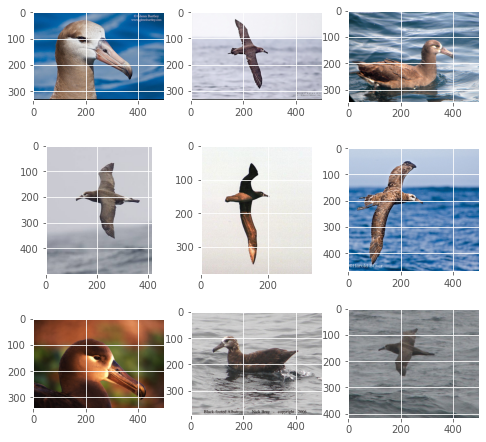

In [ ]:
#Check original image sample
check_images(trainval)

Then we use our first function to make the images the same size:

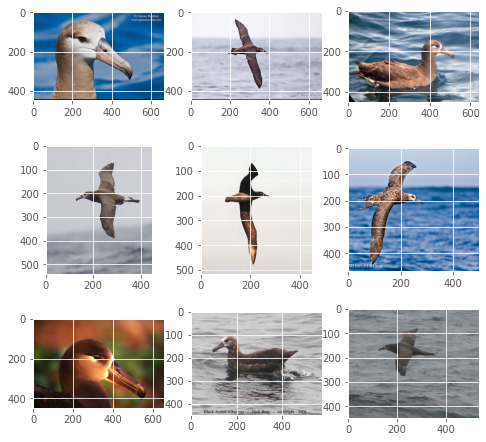

In [ ]:
#Resize images to 448 x 448
trainval_resized = resize_images(trainval, size_target=(448,448), flg_keep_aspect=True)
check_images(trainval_resized)

It can be seen that the scales of the images are now all to 448 x 448 instead of the random pixel values in the first image.

Next, we crop the images about their centre points to better focus on the birds. We make a copy of the resized images, because we want to see the effects of individual techniques rather than the combined results.

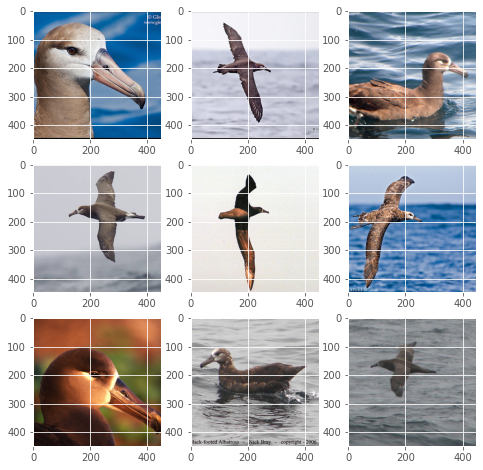

In [ ]:
#Centre-crop images

#Make a copy of the resized images so we don't modify the original ones
trainval_resized_cropped = trainval_resized.copy()

#Use a for loop to crop the resized images
for i in range(9):
    trainval_resized_cropped[i] = center_crop_image(trainval_resized_cropped[i])

check_images(trainval_resized_cropped)

It can be seen that the images have been cropped. They are still 448 x 448 so we have not lost the resizing. The birds are clearer than in the resized pictures; although there are some (e.g. bottom left) that have cropped out some of the bird's features.  
  
A suggested future improvement here would be to use the bounding boxes provided in the dataset to crop the images instead of using a centre crop.

Now we can use some data augmentation techniques on the resized images. First, we randomlu horizontally flip some of the images (~50%):

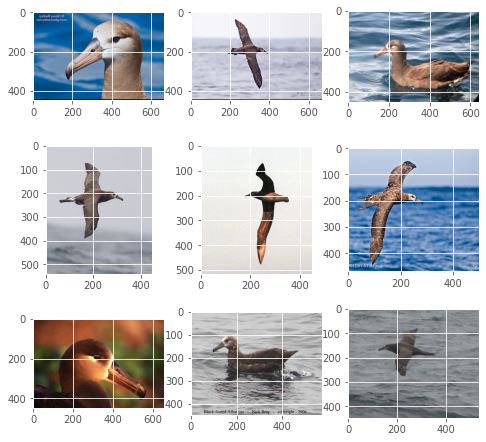

In [ ]:
#Randomly horizontally flip images

#Make a copy of the resize images
trainval_resized_flipped = trainval_resized.copy()

#Use a for loop to randomly flip
for i in range(9):
    trainval_resized_flipped[i] = horizontal_flip_image(trainval_resized_flipped[i])

check_images(trainval_resized_flipped)

4 of the images have now been flipped, which is about half as expected.

Lastly, we can randomly crop some of the images to reflect the random nature of the actual dataset:

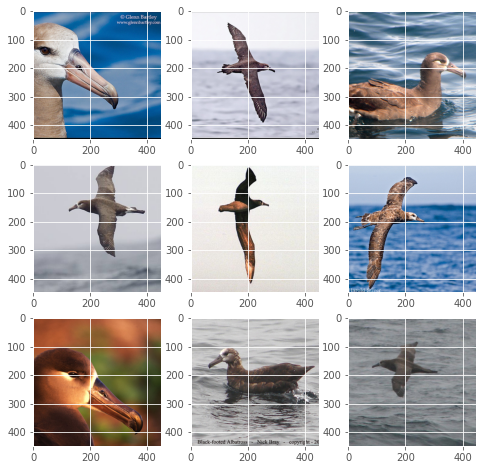

In [ ]:
#Randomly crop images

#Make a copy of the resized images
trainval_resized_cropped = trainval_resized.copy()

#Use a for loop to randomly crop some of the images
for i in range(9):
    trainval_resized_cropped[i] = random_crop_image(trainval_resized_cropped[i])

check_images(trainval_resized_cropped)

Here, we can see some of the images have now been randomly cropped as expected.

##Preprocessing the Training Data

Before we can create our preprocessing pipeline, we will use Keras' preprocessing package to augment batches of the data randomly, adding to the already random nature of the data augmentation techniques. This function will then be used in the pipeline:

In [ ]:
import keras.backend as backend
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img

#Define a function that gets batches of training data
class DirectoryIterator(keras.preprocessing.image.DirectoryIterator):
    def _get_batches_of_transformed_samples(self, index_array):
        
        batch_x = np.zeros(
            (len(index_array),) + self.image_shape,
            dtype=backend.floatx())
        grayscale = self.color_mode == 'grayscale'
        
        #build batch of image data
        for i, j in enumerate(index_array):
            fname = self.filenames[j]
            img = load_img(os.path.join(self.directory, fname),
                           grayscale=grayscale,
                           target_size=None,
                           interpolation=self.interpolation)
            x = img_to_array(img, data_format=self.data_format)
            #pillow images should be closed after `load_img`, but not PIL images
            if hasattr(img, 'close'):
                img.close()
            x = self.image_data_generator.standardize(x)
            batch_x[i] = x
            
        #optionally save augmented images to disk for debugging purposes
        if self.save_to_dir:
            for i, j in enumerate(index_array):
                img = array_to_img(batch_x[i], self.data_format, scale=True)
                fname = '{prefix}_{index}_{hash}.{format}'.format(
                    prefix=self.save_prefix,
                    index=j,
                    hash=np.random.randint(1e7),
                    format=self.save_format)
                img.save(os.path.join(self.save_to_dir, fname))
                
        #build batch of labels
        if self.class_mode == 'input':
            batch_y = batch_x.copy()
        elif self.class_mode == 'sparse':
            batch_y = self.classes[index_array]
        elif self.class_mode == 'binary':
            batch_y = self.classes[index_array].astype(backend.floatx())
        elif self.class_mode == 'categorical':
            batch_y = np.zeros(
                (len(batch_x), self.num_classes),
                dtype=backend.floatx())
            for i, label in enumerate(self.classes[index_array]):
                batch_y[i, label] = 1.
        else:
            return batch_x
        
        return batch_x, batch_y

#Define a function that implements the DirectoryIterator to find training/test images
class ImageDataGenerator(keras.preprocessing.image.ImageDataGenerator):
    def flow_from_directory(self, directory,
                            target_size=(256, 256), color_mode='rgb',
                            classes=None, class_mode='categorical',
                            batch_size=16, shuffle=True, seed=None,
                            save_to_dir=None,
                            save_prefix='',
                            save_format='png',
                            follow_links=False,
                            subset=None,
                            interpolation='nearest'):

        return DirectoryIterator(
            directory, self,
            target_size=target_size, color_mode=color_mode,
            classes=classes, class_mode=class_mode,
            data_format=self.data_format,
            batch_size=batch_size, shuffle=shuffle, seed=seed,
            save_to_dir=save_to_dir,
            save_prefix=save_prefix,
            save_format=save_format,
            follow_links=follow_links,
            subset=subset,
            interpolation=interpolation)

Now we can define the preprocessing pipeline without having to include the large function definitions above:

In [ ]:
#Define a function for the preprocessing pipeline
def load_data(
    path_data_train=None,
    path_data_valid=None,
    size_width=448,
    size_heigth=448,
    size_mini_batch=16,
    flg_debug=False,
    **kwargs):
                    
    #set preprocessing functions

    #for the training data, we do preprocessing and augmentation  
    func_train = lambda x :normalize_image(random_crop_image(
                                    horizontal_flip_image(
                                        resize_image(x, size_target=(size_heigth,size_width), flg_keep_aspect=True))),
                                        mean=[123.82988033, 127.3509729, 110.25606303])
    #for the test data, we only do basic preprocessing
    func_valid = lambda x :normalize_image(center_crop_image(
                                    resize_image(x, size_target=(size_heigth,size_width), flg_keep_aspect=True)),
                                    mean=[123.82988033, 127.3509729, 110.25606303])
    
    #set image_data_generator and define paths to files
    gen_train = ImageDataGenerator(preprocessing_function=func_train)

    gen_valid = ImageDataGenerator(preprocessing_function=func_valid)

    #create train and test datasets that have been preprocessed and augmented
    gen_dir_train = gen_train.flow_from_directory(path_data_train,
                                                  target_size=(size_heigth, size_width),
                                                  batch_size=size_mini_batch)

    gen_dir_valid = gen_valid.flow_from_directory(path_data_valid,
                                                  target_size=(size_heigth, size_width),
                                                  batch_size=size_mini_batch,
                                                  shuffle=False)

    return gen_dir_train, gen_dir_valid

Now we can use to function to create our final datasets for use in the models:

In [ ]:
#Create preprocessed datasets
gen_dir_train, gen_dir_valid = load_data(path_data_train='/content/drive/MyDrive/CMT307_15/CUB_200_2011/images_sorted/train',
                                         path_data_valid='/content/drive/MyDrive/CMT307_15/CUB_200_2011/images_sorted/test',
                                         size_mini_batch=9)

Found 5994 images belonging to 200 classes.
Found 5794 images belonging to 200 classes.


We can see that the train-test split is about equal, with ~6000 images in each dataset.

The last thing we can do is check that the preprocessing pipeline has worked correctly. We can use the .next() function to extract a sample from the training dataset and plot it:

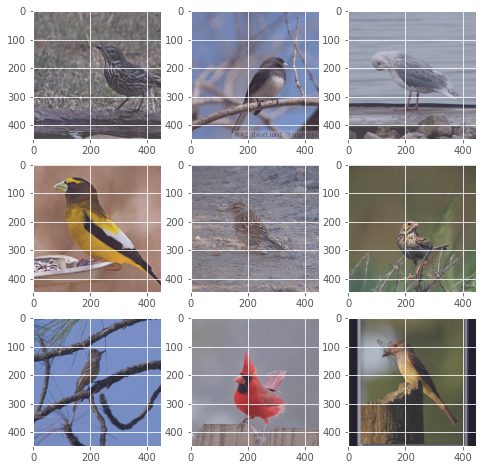

In [ ]:
# check the result of preprocessing.
x_train, y_train = gen_dir_train.next()

# convert from integers to floats
pixels = x_train.astype('float32')

# normalize to the range 0-1
pixels = (pixels - np.min(pixels))/ (np.max(pixels) - np.min(pixels))

#Check images now they are normalised to fit imshow standards
check_images(pixels)

#Implementation and Results

Now that we have created our preprocessed, augmented training data, we can train our models and test them using the validation dataset.  
  
We will use the same functions to fine-tune the models and evaluate their performance. This allows us to fairly compare all of the models.

First, we will create a function that fine-tunes the model.  
  
The model will first be fine-tuned very basically by conducting 10 runs (epochs) on the unfrozen layers of the network. It will then be trained more thoroughly on all hidden layers over a defined number of epochs with early stopping included.

In [ ]:
#Define a function that fine-tunes the model

def fine_tuning_model(model, optimizer, batch_size, epochs, frozen_number):

  #basic training with base layers frozen
  for layer in model.layers[:frozen_number]:
    layer.trainable = False

  model.compile(optimizer = optimizer, 
                loss = "categorical_crossentropy", 
                metrics = ["accuracy"])
  
  model.fit(gen_dir_train, 
            epochs = 10, 
            batch_size = batch_size, 
            validation_split = 0.2)
  print("The step of training with base layers fixed has been completed.")

  #more in-depth training with base layers unfrozen
  for layer in model.layers[frozen_number:]:
    layer.trainable = True

  checkpoint_cb = keras.callbacks.ModelCheckpoint(model.name + ".h5", 
                                                  save_best_only = True, 
                                                  monitor = "val_loss",  
                                                  mode = "min", 
                                                  verbose = 1)

  early_stopping_cb = keras.callbacks.EarlyStopping(patience = 10, 
                                                    restore_best_weights = True, 
                                                    monitor = "val_loss", 
                                                    mode = "min", 
                                                    verbose = 1)
  
  #operation for loss plateau - decreasing lr according to loss rate
  #this factor could be changed for better performance
  reduce_lr_plateau_cb = keras.callbacks.ReduceLROnPlateau(patience = 5, 
                                                           monitor = "val_loss",
                                                           mode = "min" , 
                                                           factor = 0.1,
                                                           verbose = 1)

  model.compile(optimizer = optimizer, 
                loss = "categorical_crossentropy", 
                metrics = ["accuracy"])

  history = model.fit(gen_dir_train, batch_size = batch_size, epochs = epochs, 
                      validation_split = 0.2, 
                      callbacks = [checkpoint_cb, early_stopping_cb, reduce_lr_plateau_cb])
  
  print("The step of further training has been completed.")

  return history

Then we can create a function that plots the accuracy and loss function of the model on the training and test data over each epoch.  
  
This allows us to see the improvement in the model as it is being trained, and how many epochs it takes before early stopping is implemented.

In [ ]:
#Define the function for evaluating model performance

def history_observation(history):

  #observation of accuracy

  plt.figure(figsize = (12, 6))
  plt.subplot(121)
  plt.plot(history.history["accuracy"])
  plt.plot(history.history["val_accuracy"])
  
  plt.title("Model Accuracy")
  plt.xlabel("Epoch")
  plt.ylabel("Acccuracy")
  plt.legend(["Train", "Validation"], loc = "upper left")

  plt.show()

  #observation of loss

  plt.figure(figsize = (12, 6))
  plt.subplot(122)
  plt.plot(history.history["loss"])
  plt.plot(history.history["val_loss"])
  
  plt.title("Model Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(["Train", "Validation"], loc = "upper left")

  plt.show()

##Model 1: VGG16

The first model we have chosen to use is the VGG16 model. This is a convolutional neural network (CNN) model that uses many fully connected hidden layers to train.

First, we need to define the model and input our parameters, then print out the layers of the CNN:

In [ ]:
# define basic VGG16 model

from keras.applications import VGG16

def VGG16_model(img_rows, img_cols):
  a = keras.layers.Input(shape = (img_rows, img_cols, 3))
  a = keras.layers.Lambda(imagenet_utils.preprocess_input)(a)

  base_model = keras.applications.VGG16(input_tensor = a, 
                                        include_top = False, 
                                        weights = 'imagenet')
  
  avg = keras.layers.GlobalAveragePooling2D()(base_model.output)

  # dropout -- could be adjusted.
  a = keras.layers.Dense(1024, activation = 'relu', 
                         name = 'full_connetect_layer')(avg)

  a = keras.layers.Dropout(rate = 0.2, name = "dropout")(a)

  output = keras.layers.Dense(200, activation = 'softmax', name = 'classification')(a)

  VGG16_model = keras.Model(inputs = base_model.input, 
                            outputs = output, 
                            name = 'VGG16_Model')
  
  return VGG16_model


img_rows, img_cols = 448, 448  # could be changed -- 448， 448 / 300, 300 / 64, 64
VGG16_model = VGG16_model(img_rows,img_cols)

VGG16_model.summary()


Model: "VGG16_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 448, 448, 3)]     0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 448, 448, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 448, 448, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 448, 448, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 224, 224, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 224, 224, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 224, 224, 128)     

Next, we need to know the number of frozen layers so we can input this into the fine-tuning model:

In [ ]:
# check frozen layer number -- 21.

for i,layer in enumerate(VGG16_model.layers):
  print(i,layer.name)

0 input_2
1 lambda_1
2 block1_conv1
3 block1_conv2
4 block1_pool
5 block2_conv1
6 block2_conv2
7 block2_pool
8 block3_conv1
9 block3_conv2
10 block3_conv3
11 block3_pool
12 block4_conv1
13 block4_conv2
14 block4_conv3
15 block4_pool
16 block5_conv1
17 block5_conv2
18 block5_conv3
19 block5_pool
20 global_average_pooling2d_1
21 full_connetect_layer
22 dropout
23 classification


Lastly, we fine-tune the model and evaluate the result:

Epoch 1/5
666/666 [==============================] - 630s 946ms/step - loss: 3.2203 - accuracy: 0.2577 - val_loss: 2.5870 - val_accuracy: 0.3688
Epoch 2/5
666/666 [==============================] - 133s 200ms/step - loss: 2.0354 - accuracy: 0.4747 - val_loss: 2.1734 - val_accuracy: 0.4462
Epoch 3/5
666/666 [==============================] - 133s 199ms/step - loss: 1.4995 - accuracy: 0.6015 - val_loss: 1.9403 - val_accuracy: 0.4919
Epoch 4/5
666/666 [==============================] - 132s 199ms/step - loss: 1.0968 - accuracy: 0.6965 - val_loss: 1.7926 - val_accuracy: 0.5268
Epoch 5/5
666/666 [==============================] - 133s 200ms/step - loss: 0.8516 - accuracy: 0.7672 - val_loss: 1.7189 - val_accuracy: 0.5435
The step of training with base layers fixed has been completed.
Epoch 1/100
666/666 [==============================] - 133s 199ms/step - loss: 0.6993 - accuracy: 0.8104 - val_loss: 1.6506 - val_accuracy: 0.5675

Epoch 00001: val_loss improved from inf to 1.65055, saving mode

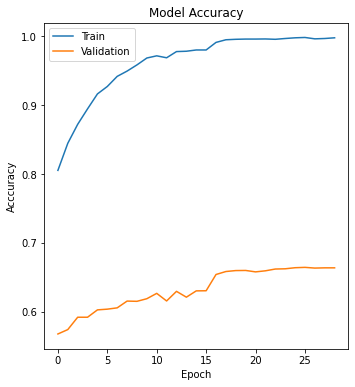

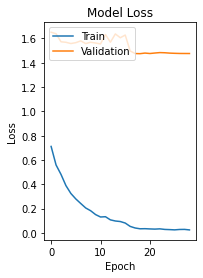

In [ ]:
# put VGG16 model into fine_tuning model for training and evaluate the result

optimizer = optimizers.Adam(lr=0.0001)
batch_size = 64  # could be changed according to the result of preprocessing -- 64 / 32 / 16
epochs = 100
frozen_number = 21

VGG16_history = fine_tuning_model(VGG16_model, optimizer, batch_size, epochs, frozen_number)

##Model 2: Bi-linear CNN

Model 2 is a bilinear CNN based on VGG16. It has 2 streams, both of which use VGG16 models.

First, we need to define the model and input our parameters, then print out the layers of the CNN:

In [ ]:
# Bilinear CNN_1 based on VGG16 model.

from keras.applications import VGG16
from keras import backend as K


def batch_dot(cnn_ab):
  return K.batch_dot(cnn_ab[0], cnn_ab[1], axes = [1, 1])

def sign_sqrt(a):
  return K.sign(a) * K.sqrt(K.abs(a) + 1e-10)

def l2_normalization(a):
  return K.l2_normalize(a, axis = -1)


# apply bilinear structure based on VGG16 model.

def Bilinear_VGG16_model(img_rows, img_cols):
  a = keras.layers.Input(shape = (img_rows, img_cols, 3))
  a = keras.layers.Lambda(imagenet_utils.preprocess_input)(a)

  base_model = keras.applications.VGG16(input_tensor = a, 
                                        include_top = False, 
                                        weights = 'imagenet', 
                                        pooling = 'avg')

  cnn_a = base_model.layers[-2].output
  cnn_shape = base_model.layers[-2].output_shape
  cnn_a = keras.layers.Reshape([cnn_shape[1] * cnn_shape[2], 
                       cnn_shape[-1]])(cnn_a)
  cnn_b = cnn_a
  cnn_dot = keras.layers.Lambda(batch_dot)([cnn_a, cnn_b])
  cnn_dot = keras.layers.Reshape([cnn_shape[-1] * cnn_shape[-1]])(cnn_dot)

  sign_sqrt_a = keras.layers.Lambda(sign_sqrt)(cnn_dot)
  l2_normal = keras.layers.Lambda(l2_normalization)(sign_sqrt_a)
  
  a = keras.layers.Dense(1024, activation = 'relu', 
                         name = 'full_connetect_layer')(l2_normal)
  
  a = keras.layers.Dropout(rate = 0.2, name = "dropout")(a)

  output = keras.layers.Dense(200, activation = 'softmax', name = 'classification')(a)

  Bilinear_VGG16_model = keras.Model(inputs = base_model.input, 
                                     outputs = output,
                                     name = 'Bilinear_VGG16_model')
  
  return Bilinear_VGG16_model

  
img_rows, img_cols = 448, 448  # could be changed -- 448， 448 / 300, 300 / 64, 64
Bilinear_VGG16_model = Bilinear_VGG16_model(img_rows,img_cols)

Bilinear_VGG16_model.summary()

Model: "Bilinear_VGG16_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 448, 448, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 448, 448, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 448, 448, 64) 1792        lambda[0][0]                     
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 448, 448, 64) 36928       block1_conv1[0][0]               
_______________________________________________________________________________

Next, we need to know the number of frozen layers so we can input this into the fine-tuning model:

In [ ]:
# check frozen layer number -- 25.

for i,layer in enumerate(Bilinear_VGG16_model.layers):
  print(i,layer.name)

0 input_1
1 lambda
2 block1_conv1
3 block1_conv2
4 block1_pool
5 block2_conv1
6 block2_conv2
7 block2_pool
8 block3_conv1
9 block3_conv2
10 block3_conv3
11 block3_pool
12 block4_conv1
13 block4_conv2
14 block4_conv3
15 block4_pool
16 block5_conv1
17 block5_conv2
18 block5_conv3
19 block5_pool
20 reshape
21 lambda_1
22 reshape_1
23 lambda_2
24 lambda_3
25 full_connetect_layer
26 dropout
27 classification


Lastly, we fine-tune the model and evaluate the result:

In [ ]:
# put bilinear CNN_1 model into fine_tuning model for training and evaluate the result

optimizer = optimizers.Adam(lr=0.0001)
batch_size = 64  # could be changed according to the result of preprocessing -- 64 / 32 / 16
epochs = 100
frozen_number = 25

Bilinear_VGG16_history = fine_tuning_model(Bilinear_VGG16_model,optimizer,batch_size,epochs,frozen_number)



Epoch 1/5
666/666 [==============================] - 726s 1s/step - loss: 5.2071 - accuracy: 0.0376 - val_loss: 4.6633 - val_accuracy: 0.2123
Epoch 2/5
666/666 [==============================] - 154s 231ms/step - loss: 4.3878 - accuracy: 0.2173 - val_loss: 3.6736 - val_accuracy: 0.3352
Epoch 3/5
666/666 [==============================] - 152s 229ms/step - loss: 3.3961 - accuracy: 0.3669 - val_loss: 2.9260 - val_accuracy: 0.4677
Epoch 4/5
666/666 [==============================] - 154s 232ms/step - loss: 2.6438 - accuracy: 0.4948 - val_loss: 2.4198 - val_accuracy: 0.5495
Epoch 5/5
666/666 [==============================] - 152s 228ms/step - loss: 2.1714 - accuracy: 0.5676 - val_loss: 2.0955 - val_accuracy: 0.5920
The step of training with base layers fixed has been completed.
Epoch 1/100
666/666 [==============================] - 153s 229ms/step - loss: 1.8161 - accuracy: 0.6281 - val_loss: 1.8618 - val_accuracy: 0.6027

Epoch 00001: val_loss improved from inf to 1.86178, saving model t

##Model 3: EfficientNet

EfficientNet is a CNN that carefully scales the network to improve efficiency.

First, we need to define the model and input our parameters, then print out the layers of the CNN:

In [ ]:
# define basic EffcientNetB4 model.

from tensorflow.keras.applications import EfficientNetB4
from keras import backend as k


def EfficientNetB4_model(img_rows, img_cols):

  # clear the session -- avoid clutter.
  k.clear_session()
  
  a = keras.layers.Input(shape = (img_rows, img_cols, 3))
 # a = keras.layers.Lambda(imagenet_utils.preprocess_input)(a)
  
  base_model = EfficientNetB4(input_tensor = a,
                              include_top = False, weights = 'imagenet')
  
  avg = keras.layers.GlobalAveragePooling2D()(base_model.output)

  # dropout -- could be adjusted.

  a = keras.layers.Dense(1024, activation = 'relu')(avg)

  a = keras.layers.Dropout(rate = 0.5)(a)

  output = keras.layers.Dense(200, activation = 'softmax', name = 'classification')(a)

  EfficientNetB4_model = keras.Model(inputs = base_model.input, 
                                     outputs = output, name = 'EfficientNetB4_Model')
  base_model.trainable = False

  return EfficientNetB4_model


img_rows, img_cols = 448, 448  # could be changed -- 448, 448 / 300, 300 / 64, 64
EfficientNetB4_model = EfficientNetB4_model(img_rows,img_cols)

EfficientNetB4_model.summary()


71688192/71686520 [==============================] - 1s 0us/step
Model: "EfficientNetB4_Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 448, 448, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 448, 448, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 448, 448, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 449, 449, 3)  0           normalization[0][0]              
______________

Next, we need to know the number of frozen layers so we can input this into the fine-tuning model:

In [ ]:
# check frozen layer number. -- 474

for i,layer in enumerate(EfficientNetB4_model.layers):
  print(i,layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block1b_dwconv
18 block1b_bn
19 block1b_activation
20 block1b_se_squeeze
21 block1b_se_reshape
22 block1b_se_reduce
23 block1b_se_expand
24 block1b_se_excite
25 block1b_project_conv
26 block1b_project_bn
27 block1b_drop
28 block1b_add
29 block2a_expand_conv
30 block2a_expand_bn
31 block2a_expand_activation
32 block2a_dwconv_pad
33 block2a_dwconv
34 block2a_bn
35 block2a_activation
36 block2a_se_squeeze
37 block2a_se_reshape
38 block2a_se_reduce
39 block2a_se_expand
40 block2a_se_excite
41 block2a_project_conv
42 block2a_project_bn
43 block2b_expand_conv
44 block2b_expand_bn
45 block2b_expand_activation
46 block2b_dwconv
47 block2b_bn
48 block2b_activation
49 block2b_se_squeeze
50 block2b_se

Lastly, we fine-tune the model and evaluate the result:

In [ ]:
# put EfficientNetB3 model into fine_tuning model for training and evaluate the result

optimizer = optimizers.RMSprop(lr=2e-5)
batch_size = 64  # could be changed according to the result of preprocessing -- 64 / 32 / 16
epochs = 200
frozen_number = 475
EfficientNetB4_history = fine_tuning_model(EfficientNetB4_model,
                                           optimizer,
                                           batch_size,
                                           epochs,
                                           frozen_number)

# EfficientNetB4_model.compile(loss = "categorical_crossentropy", optimizer = optimizer, metrics = 'accuracy')

# EfficientNetB4_history = EfficientNetB4_model.fit(gen_dir_train, batch_size = batch_size, epochs = epochs, validation_data = gen_dir_valid)

Epoch 1/5
666/666 [==============================] - 3191s 5s/step - loss: 5.2487 - accuracy: 0.0165 - val_loss: 4.8678 - val_accuracy: 0.1814
Epoch 2/5
666/666 [==============================] - 151s 227ms/step - loss: 4.7703 - accuracy: 0.1368 - val_loss: 4.3078 - val_accuracy: 0.3423
Epoch 3/5
666/666 [==============================] - 149s 224ms/step - loss: 4.2239 - accuracy: 0.2413 - val_loss: 3.7008 - val_accuracy: 0.4420
Epoch 4/5
666/666 [==============================] - 150s 225ms/step - loss: 3.6724 - accuracy: 0.3161 - val_loss: 3.1670 - val_accuracy: 0.5076
Epoch 5/5
666/666 [==============================] - 153s 230ms/step - loss: 3.1620 - accuracy: 0.3807 - val_loss: 2.7512 - val_accuracy: 0.5528
The step of training with base layers fixed has been completed.
Epoch 1/200
666/666 [==============================] - 169s 235ms/step - loss: 2.8098 - accuracy: 0.4093 - val_loss: 2.4351 - val_accuracy: 0.5856

Epoch 00001: val_loss improved from inf to 2.43515, saving model 

##Model 3b: EfficientNet with Attention

We implement an improvement on Model 3 by including attention, which enhances important features and fades others to further increase performance.

First, we need to redefine the model and input our parameters, then print out the layers of the CNN:

In [ ]:
pip install efficientnet

In [ ]:
# define the EfficientNet model with Attention mechanism.

from tensorflow.keras.applications import EfficientNetB4
from keras import backend as k


def EfficientNetB4_Attention_model(img_rows, img_cols):

  k.clear_session()

  a_input = keras.layers.Input(shape = (img_rows, img_cols, 3))
  # a = keras.layers.Lambda(imagenet_utils.preprocess_input)(a_input)

  base_model = EfficientNetB4(input_shape = (img_rows, img_cols, 3), 
                              weights = 'imagenet', 
                              include_top = False)
  
  a = base_model(a_input)
  batch_normal = keras.layers.BatchNormalization()(a)
  a = keras.layers.Dropout(rate = 0.2)(batch_normal)

  # add Attention mechanism.

  att_layer = keras.layers.Conv2D(64, kernel_size = (1, 1), padding = 'same', 
                     activation = 'relu')(a)

  att_layer = keras.layers.Conv2D(16, kernel_size = (1, 1), padding = 'same', 
                     activation = 'relu')(att_layer)

  att_layer = keras.layers.Conv2D(8, kernel_size = (1, 1), padding = 'same', 
                     activation = 'relu')(att_layer)

  att_layer = keras.layers.Conv2D(1, kernel_size = (1, 1), padding = 'same', 
                     activation = 'relu')(att_layer)

  # to all the channels.
  depth = base_model.get_output_shape_at(0)[-1]
  weight_c = np.ones((1, 1, 1, depth))
  
  a = keras.layers.Conv2D(depth, kernel_size = (1, 1), padding = 'same', 
             activation = 'linear', use_bias = False, weights = [weight_c])
  
  a.trainable = False

  att_layer = a(att_layer)

  mult = keras.layers.multiply([att_layer, batch_normal])

  gap = keras.layers.GlobalAveragePooling2D()(mult)

  gap_dropout = keras.layers.Dropout(rate = 0.2)(gap)
 
  a = keras.layers.Dense(1000, activation = 'relu')(gap_dropout)

  a = keras.layers.Dropout(rate = 0.2)(a)

  output = keras.layers.Dense(200, activation = 'softmax', name = 'classification')(a)

  EfficientNetB4_Attention_model = keras.Model(inputs = [a_input], 
                                               outputs = [output], 
                                               name = 'EfficientNetB4_Attention_model')

  return EfficientNetB4_Attention_model


img_rows, img_cols = 448, 448  # could be changed -- 448, 448 / 300, 300 / 64, 64
EfficientNetB4_Attention_model = EfficientNetB4_Attention_model(img_rows,img_cols)




In [ ]:
EfficientNetB4_Attention_model.summary()

Model: "EfficientNetB4_Attention_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 448, 448, 3) 0                                            
__________________________________________________________________________________________________
efficientnetb4 (Functional)     (None, 14, 14, 1792) 17673823    input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 14, 14, 1792) 7168        efficientnetb4[0][0]             
__________________________________________________________________________________________________
dropout (Dropout)               (None, 14, 14, 1792) 0           batch_normalization[0][0]        
_____________________________________________________________________

Next, we need to know the number of frozen layers so we can input this into the fine-tuning model:

In [ ]:
# check frozen layer number. -- 12

for i,layer in enumerate(EfficientNetB4_Attention_model.layers):
  print(i,layer.name)

0 input_1
1 efficientnetb4
2 batch_normalization
3 dropout
4 conv2d
5 conv2d_1
6 conv2d_2
7 conv2d_3
8 conv2d_4
9 multiply
10 global_average_pooling2d
11 dropout_1
12 dense
13 dropout_2
14 classification


Lastly, we fine-tune the model and evaluate the result:

In [ ]:
# put into fine_tuning model for training and evaluate the result

optimizer = optimizers.Adam(lr=0.0001)
batch_size = 64  # could be changed according to the result of preprocessing -- 64 / 32 / 16
epochs = 150
frozen_number = 12

EfficientNetB4_Attention_history = fine_tuning_model(EfficientNetB4_Attention_model,
                                           optimizer,
                                           batch_size,
                                           epochs,
                                           frozen_number)



Epoch 1/5
666/666 [==============================] - 817s 1s/step - loss: 4.2191 - accuracy: 0.2362 - val_loss: 3.8869 - val_accuracy: 0.3158
Epoch 2/5
666/666 [==============================] - 150s 225ms/step - loss: 3.5082 - accuracy: 0.3635 - val_loss: 3.4557 - val_accuracy: 0.3656
Epoch 3/5
666/666 [==============================] - 151s 227ms/step - loss: 3.0584 - accuracy: 0.4155 - val_loss: 3.1523 - val_accuracy: 0.3978
Epoch 4/5
666/666 [==============================] - 147s 220ms/step - loss: 2.7684 - accuracy: 0.4548 - val_loss: 2.9274 - val_accuracy: 0.4196
Epoch 5/5
666/666 [==============================] - 146s 219ms/step - loss: 2.5206 - accuracy: 0.4959 - val_loss: 2.7447 - val_accuracy: 0.4406
The step of training with base layers fixed has been completed.
Epoch 1/150
666/666 [==============================] - 164s 229ms/step - loss: 2.3504 - accuracy: 0.5222 - val_loss: 2.6172 - val_accuracy: 0.4515

Epoch 00001: val_loss improved from inf to 2.61716, saving model t

##Model 4: DenseNet121

DenseNet-121 is a dense CNN in which all the layers are interconnected in a feed-forward fashion.

We define the model, train it and print the results of the training epochs:

In [ ]:
import tensorflow as tf
import math
import os
from tensorflow.keras.layers import Dense, Flatten, Conv2D, GlobalAveragePooling2D
from tensorflow.keras import Model

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

EPOCHS = 20
BATCH_SIZE =64
NUM_CLASSES = 200
image_height = 224
image_width = 224
channels = 3
save_model_dir = 'saved_model/model'
print(tf.test.gpu_device_name())


pretrained_model = tf.keras.applications.DenseNet121(weights='imagenet',include_top=False,input_shape=(224,224,3))
model = tf.keras.Sequential()
model.add(pretrained_model)
model.add(tf.keras.layers.GlobalAveragePooling2D())  
model.add(tf.keras.layers.Dense(512,activation='relu'))  
model.add(tf.keras.layers.Dropout(rate=0.5))  
model.add(tf.keras.layers.Dense(200,activation='softmax'))  
model.summary() 


train_dataset, valid_dataset, train_count, valid_count = generate_datasets()

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
              metrics=['accuracy']) 
 
history = model.fit(x=train_dataset,   
                    epochs=EPOCHS, 
                    validation_data=valid_dataset)  

model.save_weights(filepath=save_model_dir, save_format='tf')


/device:GPU:0
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_7 ( (None, 1024)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 200)               102600    
Total params: 7,664,904
Trainable params: 7,581,256
Non-trainable params: 83,648
_________________________________________________________________
train: 5994
test: 5794
Epoch 1/20
94/94 [==============================] - 153s 1s/step - l

##Model 5: AlexNet

AlexNet is a deep CNN that has very good accuracy.

First, we need to define the model and input our parameters, then print out the layers of the CNN:

In [ ]:
#CNN AlexNet Model
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout
from keras.layers.normalization import BatchNormalization

Alex_model=Sequential()
#1 conv layer
Alex_model.add(Conv2D(filters=96,kernel_size=(11,11),strides=(4,4),padding="valid",
                 activation="relu",input_shape=(448,448,3)))
#1 max pool layer
Alex_model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))
Alex_model.add(BatchNormalization())
#2 conv layer
Alex_model.add(Conv2D(filters=256,kernel_size=(5,5),strides=(1,1),padding="valid",
                 activation="relu"))
#2 max pool layer
Alex_model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))
Alex_model.add(BatchNormalization())
#3 conv layer
Alex_model.add(Conv2D(filters=384,kernel_size=(3,3),strides=(1,1),padding="valid",
                 activation="relu"))
#4 conv layer
Alex_model.add(Conv2D(filters=384,kernel_size=(3,3),strides=(1,1),padding="valid",
                 activation="relu"))
#5 conv layer
Alex_model.add(Conv2D(filters=256,kernel_size=(3,3),strides=(1,1),padding="valid",
                 activation="relu"))
#3 max pool layer
Alex_model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))
Alex_model.add(BatchNormalization())
Alex_model.add(Flatten())
#1 dense layer
Alex_model.add(Dense(4096,input_shape=(448,448,3),activation="relu"))
Alex_model.add(Dropout(0.4))
Alex_model.add(BatchNormalization())
#2 dense layer
Alex_model.add(Dense(4096,activation="relu"))
Alex_model.add(Dropout(0.4))
Alex_model.add(BatchNormalization())
#3 dense layer
Alex_model.add(Dense(1800,activation="relu"))
Alex_model.add(Dropout(0.4))
Alex_model.add(BatchNormalization())
#output layer
Alex_model.add(Dense(200, activation="softmax"))
Alex_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 110, 110, 96)      34944     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 54, 54, 96)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 54, 54, 96)        384       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 256)       614656    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 256)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 256)       1024      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 22, 384)       8

In [ ]:
Alex_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

Then we train the model to fit the data and print the results:

In [ ]:
Alex_model.fit(x_train, y_train, epochs=100)

Epoch 1/100
1/1 [==============================] - 6s 6s/step - loss: 6.1953 - accuracy: 0.0000e+00
Epoch 2/100
1/1 [==============================] - 4s 4s/step - loss: 5.4403 - accuracy: 0.0000e+00
Epoch 3/100
1/1 [==============================] - 4s 4s/step - loss: 3.1078 - accuracy: 0.4444
Epoch 4/100
1/1 [==============================] - 4s 4s/step - loss: 1.4599 - accuracy: 0.7778
Epoch 5/100
1/1 [==============================] - 4s 4s/step - loss: 0.6137 - accuracy: 0.8889
Epoch 6/100
1/1 [==============================] - 4s 4s/step - loss: 0.1706 - accuracy: 1.0000
Epoch 7/100
1/1 [==============================] - 4s 4s/step - loss: 0.2370 - accuracy: 1.0000
Epoch 8/100
1/1 [==============================] - 4s 4s/step - loss: 0.0515 - accuracy: 1.0000
Epoch 9/100
1/1 [==============================] - 4s 4s/step - loss: 0.0574 - accuracy: 1.0000
Epoch 10/100
1/1 [==============================] - 4s 4s/step - loss: 0.0031 - accuracy: 1.0000
Epoch 11/100
1/1 [=============

##Model 6: LeNet

LeNet is a simple CNN that AlexNet is based on, and is useful for a baseline comparison between models.

First, we need to define the model and input our parameters, then print out the layers of the CNN:

In [ ]:
##CNN LeNet Model
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Conv2D, Dense, MaxPool2D, Dropout, Flatten
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

Le_model = Sequential()
Le_model.add(Conv2D(filters=32,kernel_size=(5,5),padding='same',
                 activation='relu',input_shape=(448, 448, 3)))
Le_model.add(MaxPool2D(strides=2))
Le_model.add(Conv2D(filters=48,kernel_size=(5,5),padding='valid',
                 activation='relu'))
Le_model.add(MaxPool2D(strides=2))
Le_model.add(Flatten())
Le_model.add(Dense(256, activation='relu'))
Le_model.add(Dense(256, activation='relu'))
Le_model.add(Dense(200, activation='softmax'))
Le_model.build()
Le_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 448, 448, 32)      2432      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 224, 224, 32)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 220, 220, 48)      38448     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 110, 110, 48)      0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 580800)            0         
_________________________________________________________________
dense_11 (Dense)             (None, 256)               148685056 
_________________________________________________________________
dense_12 (Dense)             (None, 256)              

In [ ]:
adam = Adam(lr=5e-4)
Le_model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=adam)

Then we train the model to fit the data and print the results:

In [ ]:
Le_model.fit(x_train, y_train, epochs=100)

Epoch 1/100
1/1 [==============================] - 6s 6s/step - loss: 29.0067 - accuracy: 0.1111
Epoch 2/100
1/1 [==============================] - 5s 5s/step - loss: 1878.6504 - accuracy: 0.0000e+00
Epoch 3/100
1/1 [==============================] - 5s 5s/step - loss: 983.5879 - accuracy: 0.3333
Epoch 4/100
1/1 [==============================] - 5s 5s/step - loss: 475.4233 - accuracy: 0.3333
Epoch 5/100
1/1 [==============================] - 5s 5s/step - loss: 126.9645 - accuracy: 0.6667
Epoch 6/100
1/1 [==============================] - 5s 5s/step - loss: 45.5940 - accuracy: 0.8889
Epoch 7/100
1/1 [==============================] - 5s 5s/step - loss: 8.5811 - accuracy: 0.8889
Epoch 8/100
1/1 [==============================] - 5s 5s/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9/100
1/1 [==============================] - 5s 5s/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 10/100
1/1 [==============================] - 5s 5s/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 11/100

#Results Analysis

The first four models employ a `history_observation` function that plots the accuracy and loss for both the training and validation sets. A confusion matrix is also saved for each model, and is shown in the report.  
  
Models 5 and 6 were unfortunately added to the code too late to show their history and confusion matrices. Below, we present their basic accuracy scores.

##Model 1: VGG16

The model accuracy can be seen as exceptionally high for the training set, and ~60% for the validation set. This may be due to several factors: e.g. the train-test split or bad generalisation.  
  
The train-test split is the one recommended by the dataset creators, so it seems unlikely that this is the reason for lower validation accuracy. It is more likely to be that the model is not great at generalisation. However, the accuracy score is not terrible.  
  
The loss function is also worse for the validation set; the training set loss function decreases over time, as expected, but the validation loss function appears to stay relatively constant at ~1.6. This may be due to overfitting, but more analysis is needed to see if this is the case.

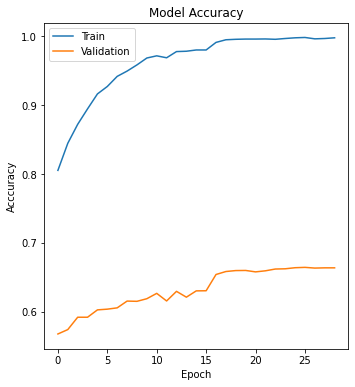

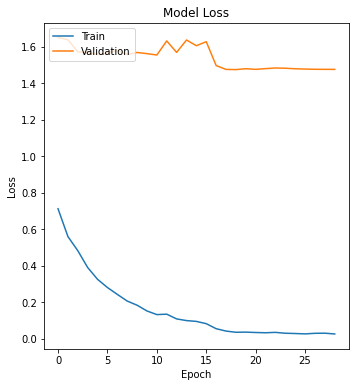

In [ ]:
history_observation(VGG16_history)

In [ ]:
def plot_confusion_matrix(cm,class_num=200,
                          title='Confusion matrix',
                          cmap= plt.get_cmap('Blues') ):
    import itertools
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(200, 160))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(class_num)
    # plt.xticks(tick_marks, classes, rotation=45)
    # plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, '{:.2f}'.format(cm[i, j]), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('./temp/matrix.jpg')
    plt.show()


#
def pred_test_data(models, data_x, data_y):
    from sklearn.metrics import confusion_matrix
    from sklearn import metrics
    prediction = models.predict(data_x)
    # Get most likely class
    predicted_classes = np.argmax(prediction, axis=1)
    true_classes = data_y
    conf_mat = confusion_matrix(y_true=true_classes, y_pred=predicted_classes)
    print(conf_mat)
    report = metrics.classification_report(true_classes, predicted_classes)
    print('test content============================>')
    print(report)

    print('evaluation index============================>')
    accuracy_score = metrics.recall_score(y_true=true_classes, y_pred=predicted_classes, average='weighted')
    print('Recall', accuracy_score)
    precision = metrics.precision_score(y_true=true_classes, y_pred=predicted_classes, average='weighted')
    print('Precision', precision)
    f1 = metrics.f1_score(y_true=true_classes, y_pred=predicted_classes, average='weighted')
    print('F1', f1)
    acc = metrics.accuracy_score(y_true=true_classes, y_pred=predicted_classes, )
    print('acc', acc)
    return conf_mat

## appraise

cm=pred_test_data(VGG16_history.model, gen_dir_valid, gen_dir_valid.classes)
plot_confusion_matrix(cm,200)

This error analysis saves the figures using Pycharm and does not show them; they are included in the Error Analysis section of the report.

##Model 2: Bi-linear CNN

The model accuracy can be seen as exceptionally high for the training set, and ~70% for the validation set. This difference is expected; since the validation accuracy is not too low this is not a problem (unlike Model 1). 
  
Both the loss functions for this model decrease over the epochs, which is expected and suggests that overfitting is not a problem here. A loss of ~1 is a good loss value for this dataset.

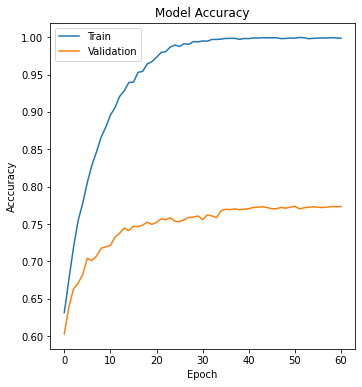

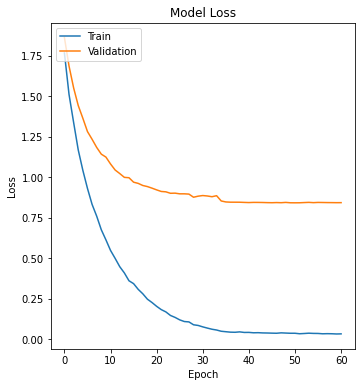

In [ ]:
history_observation(Bilinear_VGG16_history)

In [ ]:
def plot_confusion_matrix(cm,class_num=200,
                          title='Confusion matrix',
                          cmap= plt.get_cmap('Blues') ):
    import itertools
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(200, 160))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(class_num)
    # plt.xticks(tick_marks, classes, rotation=45)
    # plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, '{:.2f}'.format(cm[i, j]), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('./temp/matrix.jpg')
    plt.show()


# 
def pred_test_data(models, data_x, data_y):
    from sklearn.metrics import confusion_matrix
    from sklearn import metrics
    prediction = models.predict(data_x)
    # Get most likely class
    predicted_classes = np.argmax(prediction, axis=1)
    true_classes = data_y
    conf_mat = confusion_matrix(y_true=true_classes, y_pred=predicted_classes)
    print(conf_mat)
    report = metrics.classification_report(true_classes, predicted_classes)
    print('test content============================>')
    print(report)

    print('evaluation index============================>')
    accuracy_score = metrics.recall_score(y_true=true_classes, y_pred=predicted_classes, average='weighted')
    print('Recall', accuracy_score)
    precision = metrics.precision_score(y_true=true_classes, y_pred=predicted_classes, average='weighted')
    print('Precision', precision)
    f1 = metrics.f1_score(y_true=true_classes, y_pred=predicted_classes, average='weighted')
    print('F1', f1)
    acc = metrics.accuracy_score(y_true=true_classes, y_pred=predicted_classes, )
    print('acc', acc)
    return conf_mat

## appraise

cm=pred_test_data(Bilinear_history.model, gen_dir_valid, gen_dir_valid.classes)
plot_confusion_matrix(cm,200)

This error analysis saves the figures using Pycharm and does not show them; they are included in the Error Analysis section of the report.

##Model 3: EfficientNet

For this model, the training accuracy is not as high as Models 1 and 2. However, the validation accuracy is closer to the training accuracy, unlike the previous models. It is also higher at ~80%. This is a very good accuracy for this dataset, showing promise for this model.
  
Both the loss functions for this model decrease over the epochs, which is expected and suggests that overfitting is not a problem here. The loss value starts much higher than previous models, but results in a loss of ~1 which is a good loss value for this dataset.

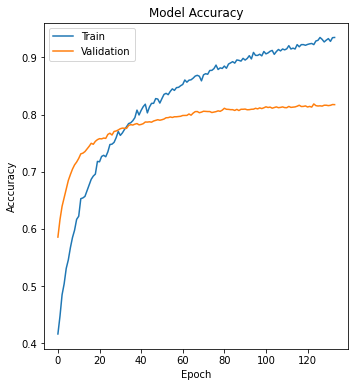

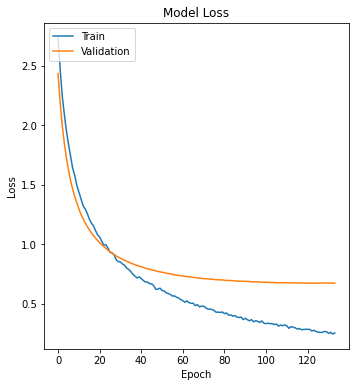

In [ ]:
history_observation(EfficientNetB4_history)

In [ ]:
def plot_confusion_matrix(cm,class_num=200,
                          title='Confusion matrix',
                          cmap= plt.get_cmap('Blues') ):
    import itertools
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(200, 160))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(class_num)
    # plt.xticks(tick_marks, classes, rotation=45)
    # plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, '{:.2f}'.format(cm[i, j]), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('./temp/matrix.jpg')
    plt.show()


# 
def pred_test_data(models, data_x, data_y):
    from sklearn.metrics import confusion_matrix
    from sklearn import metrics
    prediction = models.predict(data_x)
    # Get most likely class
    predicted_classes = np.argmax(prediction, axis=1)
    true_classes = data_y
    conf_mat = confusion_matrix(y_true=true_classes, y_pred=predicted_classes)
    print(conf_mat)
    report = metrics.classification_report(true_classes, predicted_classes)
    print('test content============================>')
    print(report)

    print('evaluation index============================>')
    accuracy_score = metrics.recall_score(y_true=true_classes, y_pred=predicted_classes, average='weighted')
    print('Recall', accuracy_score)
    precision = metrics.precision_score(y_true=true_classes, y_pred=predicted_classes, average='weighted')
    print('Precision', precision)
    f1 = metrics.f1_score(y_true=true_classes, y_pred=predicted_classes, average='weighted')
    print('F1', f1)
    acc = metrics.accuracy_score(y_true=true_classes, y_pred=predicted_classes, )
    print('acc', acc)
    return conf_mat

## appraise

cm=pred_test_data(EfficientNetB4_history.model, gen_dir_valid, gen_dir_valid.classes)
plot_confusion_matrix(cm,200)


This error analysis saves the figures using Pycharm and does not show them; they are included in the Error Analysis section of the report.

##Model 3b: EfficientNetB4 with Attention

Attention was used to attempt to improve Model 3, since it showed the highest validation accuracy so far. However, whilst the training accuracy has stayed the same, the validation accuracy is actually lower than before the addition of attention, suggesting that this is not optimising the model.
  
Both the loss functions for this model decrease over the epochs, which is expected and suggests that overfitting is not a problem here. The final validation loss value of ~1.5 is higher than previous models, once again suggesting that the addition of attention is not optimal for Model 3.

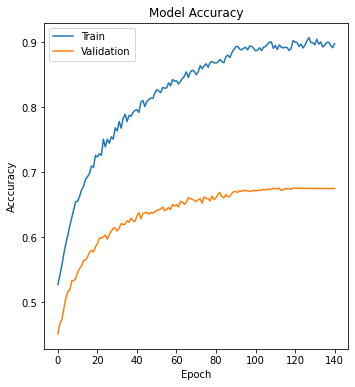

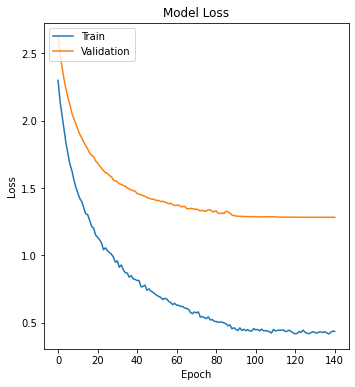

In [ ]:
history_observation(EfficientNetB4_Attention_history)

In [ ]:
def plot_confusion_matrix(cm,class_num=200,
                          title='Confusion matrix',
                          cmap= plt.get_cmap('Blues') ):
    import itertools
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(200, 160))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(class_num)
    # plt.xticks(tick_marks, classes, rotation=45)
    # plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, '{:.2f}'.format(cm[i, j]), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('./temp/matrix.jpg')
    plt.show()

def pred_test_data(models, data_x, data_y):
    from sklearn.metrics import confusion_matrix
    from sklearn import metrics
    prediction = models.predict(data_x)
    # Get most likely class
    predicted_classes = np.argmax(prediction, axis=1)
    true_classes = data_y
    conf_mat = confusion_matrix(y_true=true_classes, y_pred=predicted_classes)
    print(conf_mat)
    report = metrics.classification_report(true_classes, predicted_classes)
    print('test content============================>')
    print(report)

    print('evaluation index============================>')
    accuracy_score = metrics.recall_score(y_true=true_classes, y_pred=predicted_classes, average='weighted')
    print('Recall', accuracy_score)
    precision = metrics.precision_score(y_true=true_classes, y_pred=predicted_classes, average='weighted')
    print('Precision', precision)
    f1 = metrics.f1_score(y_true=true_classes, y_pred=predicted_classes, average='weighted')
    print('F1', f1)
    acc = metrics.accuracy_score(y_true=true_classes, y_pred=predicted_classes, )
    print('acc', acc)
    return conf_mat

## appraise

cm=pred_test_data(EfficientNetB4_Attention_history.model, gen_dir_valid, gen_dir_valid.classes)
plot_confusion_matrix(cm,200)

This error analysis saves the figures using Pycharm and does not show them; they are included in the Error Analysis section of the report.

##Model 4: DenseNet121

The training accuracy for this model is very good, at almost 100%. The validation accuracy reaches ~70%, which is not the highest model accuracy but still a very good score. This model has potential.  
  
The loss values of the model decrease over time as expected. The final validation loss value of ~1 is a good loss value for this dataset.

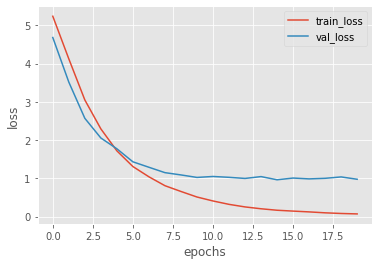

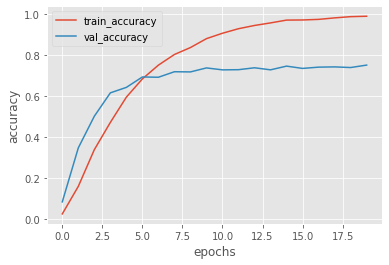

In [ ]:
import matplotlib.pyplot as plt


history_dict = history.history
train_loss = history_dict['loss'] 
train_accuracy = history_dict['accuracy']   
val_loss = history_dict['val_loss']  
val_accuracy = history_dict['val_accuracy'] 

plt.figure()
plt.plot(range(EPOCHS), train_loss, label='train_loss')
plt.plot(range(EPOCHS), val_loss, label='val_loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')

plt.figure()
plt.plot(range(EPOCHS), train_accuracy, label='train_accuracy')
plt.plot(range(EPOCHS), val_accuracy, label='val_accuracy')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

The confusion matrix presented here is also shown in the report.

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
import itertools
def plot_confusion_matrix(cm,title='Confusion matrix',cmap=None,normalize=False):
    accuracy = np.trace(cm) / float(np.sum(cm)) 
    misclass = 1 - accuracy 
    if cmap is None:
        cmap = plt.get_cmap('Blues') 
    plt.figure(figsize=(200, 160)) 
    plt.imshow(cm, interpolation='nearest', cmap=cmap) 
    plt.title(title) 
    plt.colorbar() 

    if normalize:
        cm = cm.astype('float32') / cm.sum(axis=1)
        cm = np.round(cm,2)
        

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize: 
            plt.text(j, i, '{:0.2f}'.format(cm[i, j]), 
                     horizontalalignment='center',  
                     color='white' if cm[i, j] > thresh else 'black')  
        else: 
            plt.text(j, i, '{:,}'.format(cm[i, j]),
                     horizontalalignment="center", 
                     color='white' if cm[i, j] > thresh else 'black')

    plt.tight_layout() 
    plt.ylabel('True label') 
    plt.xlabel('Predicted label\naccuracy={:0.4f}\n misclass={:0.4f}'.format(accuracy, misclass)) 
    plt.show() 


label_list = []
pred_list = []
cnt = 0
for valid_images, valid_labels in valid_dataset:
    label_list += list(valid_labels)
    predictions = model(valid_images ,training=False )
    pred_class = np.argmax(predictions, axis = 1)
    pred_list += list(pred_class)


confusion_mtx = confusion_matrix(y_true = label_list ,y_pred = pred_list)
plot_confusion_matrix(confusion_mtx, normalize=True)



The number of incorrect predictions and some of the incorrectly predicted labels have been presented here. The model incorrectly labelled 1589 images.

Number of incorrect predictions:  1589
../CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0046_18.jpg


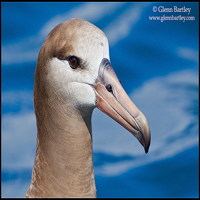

ground truth: 080.Green_Kingfisher
prediction: 082.Ringed_Kingfisher
../CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0002_55.jpg


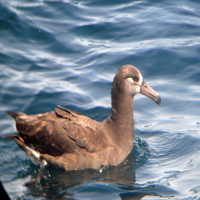

ground truth: 141.Artic_Tern
prediction: 146.Forsters_Tern
../CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0085_92.jpg


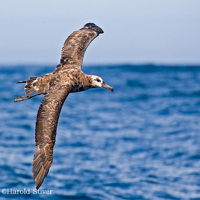

ground truth: 078.Gray_Kingbird
prediction: 135.Bank_Swallow
../CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0025_796057.jpg


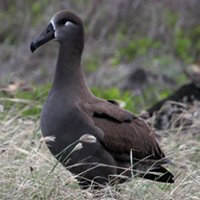

ground truth: 069.Rufous_Hummingbird
prediction: 068.Ruby_throated_Hummingbird
../CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0086_796062.jpg


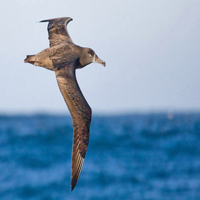

ground truth: 091.Mockingbird
prediction: 049.Boat_tailed_Grackle
../CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0049_796063.jpg


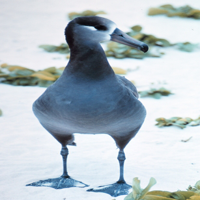

ground truth: 037.Acadian_Flycatcher
prediction: 039.Least_Flycatcher
../CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0006_796065.jpg


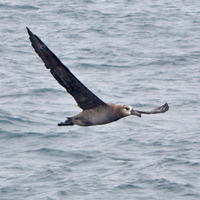

ground truth: 097.Orchard_Oriole
prediction: 161.Blue_winged_Warbler
../CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0016_796067.jpg


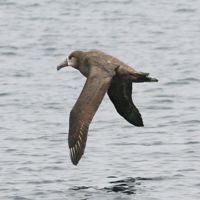

ground truth: 056.Pine_Grosbeak
prediction: 148.Green_tailed_Towhee
../CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0065_796068.jpg


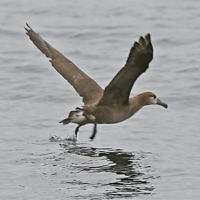

ground truth: 163.Cape_May_Warbler
prediction: 176.Prairie_Warbler
../CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0042_796071.jpg


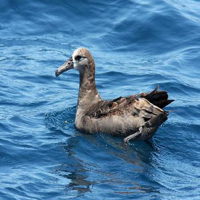

ground truth: 117.Clay_colored_Sparrow
prediction: 128.Seaside_Sparrow


In [ ]:
from PIL import Image
import random
path_list = []
train_val_list = []
class_name_list = []
data_root = '/content/drive/MyDrive/CMT307_15/CUB_200_2011/images'
fp = open('/content/drive/MyDrive/CMT307_15/CUB_200_2011/images.txt')
for line in fp:
    items = line.strip().split()
    path_list.append(os.path.join(data_root,items[1]))
fp.close()


fp = open('/content/drive/MyDrive/CMT307_15/CUB_200_2011/train_test_split.txt')
for line in fp:
    items = line.strip().split()
    train_val_list.append(int(items[1]))
fp.close()


fp = open('/content/drive/MyDrive/CMT307_15/CUB_200_2011/classes.txt')
for line in fp:
    items = line.strip().split()
    class_name_list.append(items[1])
fp.close()

val_img_path_list = [x for i, x in zip(train_val_list, path_list) if i==0]


num_pre = 10
pre_list = [item for item in  zip(img_path_list, pred_list, label_list) if item[1]!=item[2]]
print('Number of incorrect predictions: ',len(pre_list))
pre_list = random.sample(pre_list, num_pre)

for i in range(len(pre_list)):
    img_path, pred, label = pre_list[i]
    if pred != label:
        print(val_img_path_list[i])
        img = Image.open(val_img_path_list[i])
        img = img.resize((200,200))
        display(img)
        print('ground truth:',class_name_list[label])
        print('prediction:',class_name_list[pred])

##Model 5 and 6: AlexNet and LeNet

Unfortunately, Models 5 and 6 were added to the code too late for in-depth error analysis, but the basic scores have been presented below.  
  
For AlexNet, the loss function is not as good as other models at ~1.5. The validation accuracy is one of the highest however, with a score of ~80%.  
  
For LeNet, the loss function is extremely large at ~107 and the accuracy is very low at ~22%, making this the worst model performance.

In [ ]:
score = Alex_model.evaluate(x_vaild, y_vaild, batch_size=32)
print(score)

1/1 [==============================] - 0s 60ms/step - loss: 1.5367 - accuracy: 0.7778
[1.5367166996002197, 0.7777777910232544]


In [ ]:
score = Le_model.evaluate(x_vaild, y_vaild, batch_size=32)
print(score)

1/1 [==============================] - 1s 1s/step - loss: 107.1734 - accuracy: 0.2222
[107.17339324951172, 0.2222222238779068]
